









# 1. The World Bank's international debt data
<p>No es que los humanos solo tengamos deudas para administrar nuestras necesidades. Un país también puede endeudarse para administrar su economía. Por ejemplo, el gasto en infraestructura es un ingrediente costoso requerido para que los ciudadanos de un país lleven una vida cómoda. El Banco Mundial es la organización que proporciona deuda a los países.</p>

<!-- <p>En este notebook, vamos a analizar los datos de la deuda internacional recopilados por el Banco Mundial. El conjunto de datos contiene información sobre el monto de la deuda (en USD) que deben los países en desarrollo en varias categorías.</p>  -->
    

<p>Vamos a encontrar las respuestas a preguntas como:

<p>¿Cuál es el monto total de la deuda que deben los países enumerados en el conjunto de datos?
<p>¿Qué país posee la cantidad máxima de deuda y cómo se ve esa cantidad?
<p>¿Cuál es el monto promedio de la deuda de los países a través de diferentes indicadores de deuda?
    
Además tenemos otro dataset en el que encontramos información histórica de algunos índices de desarrollo, entre los que se encuentran algunos de deuda como son:

Series Name,Series Code
"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN

"Central government debt, total (current LCU)",GC.DOD.TOTL.CN

"Central government debt, total (% of GDP)",GC.DOD.TOTL.GD.ZS

# METADATOS
## DATA SET DESARROLLO
Birth rate, crude (per 1,000 people),SP.DYN.CBRT.IN
* Cause of death, by injury (% of total),SH.DTH.INJR.ZS
* Central government debt, total (current LCU),GC.DOD.TOTL.CN
* Central government debt, total (% of GDP),GC.DOD.TOTL.GD.ZS
* Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age),SH.ALC.PCAP.LI
* Total alcohol consumption per capita, female (liters of pure alcohol, projected estimates, female 15+ years of age),SH.ALC.PCAP.FE.LI
* Total alcohol consumption per capita, male (liters of pure alcohol, projected estimates, male 15+ years of age),SH.ALC.PCAP.MA.LI

## DATA SET DEUDA

indicator_name,indicator_code
* Disbursements on external debt, long-term (DIS, current US$),DT.DIS.DLXF.CD
* Interest payments on external debt, long-term (INT, current US$),DT.INT.DLXF.CD
* PPG, bilateral (AMT, current US$),DT.AMT.BLAT.CD
* PPG, bilateral (DIS, current US$),DT.DIS.BLAT.CD
* PPG, bilateral (INT, current US$),DT.INT.BLAT.CD
* PPG, multilateral (AMT, current US$),DT.AMT.MLAT.CD
* PPG, multilateral (DIS, current US$),DT.DIS.MLAT.CD
* PPG, multilateral (INT, current US$),DT.INT.MLAT.CD
* PPG, official creditors (AMT, current US$),DT.AMT.OFFT.CD
* PPG, official creditors (DIS, current US$),DT.DIS.OFFT.CD
* PPG, official creditors (INT, current US$),DT.INT.OFFT.CD
* Principal repayments on external debt, long-term (AMT, current US$),DT.AMT.DLXF.CD
* Interest payments on external debt, private nonguaranteed (PNG) (INT, current US$),DT.INT.DPNG.CD
* PPG, bonds (AMT, current US$),DT.AMT.PBND.CD
* PPG, bonds (INT, current US$),DT.INT.PBND.CD
* PPG, commercial banks (AMT, current US$),DT.AMT.PCBK.CD
* PPG, commercial banks (DIS, current US$),DT.DIS.PCBK.CD
* PPG, commercial banks (INT, current US$),DT.INT.PCBK.CD
* PPG, other private creditors (AMT, current US$),DT.AMT.PROP.CD
* PPG, other private creditors (DIS, current US$),DT.DIS.PROP.CD
* PPG, other private creditors (INT, current US$),DT.INT.PROP.CD
* PPG, private creditors (AMT, current US$),DT.AMT.PRVT.CD
* PPG, private creditors (DIS, current US$),DT.DIS.PRVT.CD
* PPG, private creditors (INT, current US$),DT.INT.PRVT.CD
* Principal repayments on external debt, private nonguaranteed (PNG) (AMT, current US$),DT.AMT.DPNG.CD

### 1. Inicializar y cargar el contexto spark


##### EN COLAB


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
# en primer lugar inicio el contexto de Spark
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

#debido a qeu trabajaremos con spark sql introducimos el sparksql
from pyspark.sql import *
spark = SparkSession.builder.master("local[*]").getOrCreate()

import re
import numpy as np
import pandas as pd

##### EN JUPYTER VIA DOCKER


In [ ]:
from pyspark import SparkContext 
from pyspark.sql import *
import seaborn as sns
import numpy as np
sc = SparkContext()
spark = SparkSession.builder.master("local[*]").getOrCreate()

conf = sc.getConf()
conf.getAll()

[('spark.app.id', 'local-1609433597108'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '44703'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'localhost'),
 ('spark.app.name', 'pyspark-shell')]

#### Parseado


In [ ]:
# importamos los csv y los pasamos a RDD

deuda_RDD = sc.textFile("indicadores_deuda.csv")
desarrollo_RDD = sc.textFile("indicadores_desarrollo.csv" )

#### Data set Desarrollo

In [ ]:
# EDA de el RDD

desarrollo_RDD_top = desarrollo_RDD.take(1)[0] # seleccionamos la primera fila
desarrollo_RDD = desarrollo_RDD.filter(lambda x: x != desarrollo_RDD_top) # eliminamos la primera fila
print(desarrollo_RDD.count()) 
desarrollo_RDD.take(3)

134


['Albania,ALB,2014 [YR2014],1023040800000,73.3202469198429,12.259',
 'Albania,ALB,2015 [YR2015],1145500940000,79.8644448747259,12.197',
 'Albania,ALB,2016 [YR2016],1188814490000,80.7355748396923,12.08']

In [ ]:
def parseo_desarrollo_1(fila): # dos posibilidades de parseado
  """
  Función que indica cual de los dos regex sigue una determinada fila
  """
  regex = re.search('(\D+)\,(\D+)\,(\d{4}) \[\S{6}\]\,(\S+)\,(\S+)\,(\S+)',fila) # Paises sin espacios ni comas
  if regex is None:
    regex = re.search('(\D+\,\s+)[\D+]\,(\d{4}) \[\S{6}\]\,(\S+)\,(\S+)\,(\S+)',fila) # Con espacios, comillas o comas
  if regex is None:
    return (fila, 0)  # devuelve si coincide con uno u otro criterio anterior
  else:
    return (fila, 1)


In [ ]:
def parseo_desarrollo_2(fila): 

  """ 
  Función que devuelve la fila parseada
  """
  
  regex = re.search("(\D+)\,(\D+)\,(\d{4}) \[\S{6}\]\,(\S+)\,(\S+)\,(\S+)", fila)
  if regex is None:
    regex  = re.search("(\D+\,\s+)[\D+]\,(\d{4}) \[\S{6}\]\,(\S+)\,(\S+)\,(\S+)", fila)
  return(regex.groups())


In [ ]:
# division de las lineas en función de la rgex a aplicar
# primera expresion regex
#segunda expresión regex

parsed_rdd = desarrollo_RDD.map(lambda line: parseo_desarrollo_1(line)).filter(lambda line: line[1] == 1).map(lambda line : line[0]) 

 # aplica el parseo en función de lo anterior
desarrollo_parseado = parsed_rdd.map(lambda line: parseo_desarrollo_2(line))

print(desarrollo_RDD.count())
desarrollo_parseado.take(5)

134


[('Albania', 'ALB', '2014', '1023040800000', '73.3202469198429', '12.259'),
 ('Albania', 'ALB', '2015', '1145500940000', '79.8644448747259', '12.197'),
 ('Albania', 'ALB', '2016', '1188814490000', '80.7355748396923', '12.08'),
 ('Australia', 'AUS', '2014', '674700000', '0.042207528166503', '13.2'),
 ('Australia', 'AUS', '2015', '762718000', '0.0469480198522591', '12.9')]


# Deuda

In [ ]:
# seleccionamos la primera fila
deuda_RDD_top = deuda_RDD.take(1)[0] 
deuda_RDD = deuda_RDD.filter(lambda x: x != deuda_RDD_top) # eliminamos la primera fila

In [ ]:
deuda_RDD.take(2)

['Afghanistan,AFG,61739336.9,100847181.9,,39107845,100847181.9,,,,,49114729.4,72894453.7,23779724.3,72894453.7,,,,39903620.1,53239440.1,,13335820,53239440.1,,,,',
 'Albania,ALB,54250280.6,790248675.2,514185620,182197616.7,236447897.3,0,39445139.5,170018.4,39615157.9,76050616.1,317194512.5,234321242.3,310371858.4,4542664.9,2279989.2,6822654.1,13847333.6,165602386.9,87884000,28101536.1,41948869.7,31030688.2,4618504.3,120324.7,35769517.2']

In [ ]:
def parseo_deuda_1(line):
  """
  Esta función susutituye caracteres qeu pueden dar problemas como las comillas o diferentes patrones.
  Las sustituyen por espacios
  """
  match = re.sub(r'"','',line)
  x = re.sub(r'\,\s{1}',' ',match)
  return x

In [ ]:
#aplicamos sustitución

deuda_parseado = deuda_RDD.map(parseo_deuda_1).map(lambda x: x.split(",")) # parseado por comas

In [ ]:
deuda_parseado.take(3)

[['Afghanistan',
  'AFG',
  '61739336.9',
  '100847181.9',
  '',
  '39107845',
  '100847181.9',
  '',
  '',
  '',
  '',
  '49114729.4',
  '72894453.7',
  '23779724.3',
  '72894453.7',
  '',
  '',
  '',
  '39903620.1',
  '53239440.1',
  '',
  '13335820',
  '53239440.1',
  '',
  '',
  '',
  ''],
 ['Albania',
  'ALB',
  '54250280.6',
  '790248675.2',
  '514185620',
  '182197616.7',
  '236447897.3',
  '0',
  '39445139.5',
  '170018.4',
  '39615157.9',
  '76050616.1',
  '317194512.5',
  '234321242.3',
  '310371858.4',
  '4542664.9',
  '2279989.2',
  '6822654.1',
  '13847333.6',
  '165602386.9',
  '87884000',
  '28101536.1',
  '41948869.7',
  '31030688.2',
  '4618504.3',
  '120324.7',
  '35769517.2'],
 ['Algeria',
  'DZA',
  '95188724.6',
  '171185188.1',
  '75420000',
  '0',
  '95188724.6',
  '',
  '576463.5',
  '0',
  '576463.5',
  '10320772.2',
  '10320772.2',
  '',
  '10320772.2',
  '',
  '',
  '',
  '7680627.6',
  '19031728.7',
  '3220000',
  '8094779',
  '15775406.6',
  '',
  '13192.3'

### 2. Número de países distintos en cada dataset. Coinciden?

In [ ]:
paises_desarrollo = desarrollo_parseado\
.map(lambda x: (x[0],1)) #selecionamos el nombre del pais y un uno por cada vez que esté el pais

paises_desarrollo.count() 

134

In [ ]:
paises_desarrollo = paises_desarrollo\
.reduceByKey(lambda a, b: a + b) #paises en el data set de desarrollo


paises_desarrollo.collect()

[('Albania', 3),
 ('Australia', 3),
 ('"Bahamas, The"', 3),
 ('Barbados', 2),
 ('Belize', 1),
 ('Bhutan', 3),
 ('Botswana', 3),
 ('Brazil', 3),
 ('El Salvador', 3),
 ('Guatemala', 3),
 ('Hungary', 3),
 ('Ireland', 3),
 ('Kazakhstan', 3),
 ('"Korea, Rep."', 3),
 ('Kyrgyz Republic', 3),
 ('Malawi', 4),
 ('Palau', 3),
 ('Peru', 3),
 ('Philippines', 1),
 ('Russian Federation', 3),
 ('Solomon Islands', 3),
 ('St. Kitts and Nevis', 1),
 ('St. Vincent and the Grenadines', 1),
 ('Switzerland', 3),
 ('Thailand', 2),
 ('Ukraine', 3),
 ('United States', 3),
 ('Uruguay', 3),
 ('Zambia', 2),
 ('Belarus', 3),
 ('Colombia', 3),
 ('Georgia', 3),
 ('Indonesia', 3),
 ('Jamaica', 3),
 ('Japan', 3),
 ('Jordan', 2),
 ('Malaysia', 3),
 ('"Micronesia, Fed. Sts."', 3),
 ('Moldova', 3),
 ('Namibia', 1),
 ('New Zealand', 3),
 ('Papua New Guinea', 2),
 ('San Marino', 2),
 ('Seychelles', 2),
 ('Singapore', 3),
 ('Spain', 3),
 ('Sri Lanka', 2),
 ('St. Lucia', 1),
 ('Tonga', 3),
 ('Turkey', 3),
 ('United Kingdom', 

In [ ]:
paises_deuda = deuda_parseado\
.map(lambda x: (x[0],1))\
.reduceByKey(lambda a, b: a + b) #paises en el data set de deuda y las veces repetido

In [ ]:
paises_deuda.collect()

[('Albania', 1),
 ('Algeria', 1),
 ('Angola', 1),
 ('Belize', 1),
 ('Bhutan', 1),
 ('Botswana', 1),
 ('Brazil', 1),
 ('Cabo Verde', 1),
 ('Cambodia', 1),
 ('China', 1),
 ('Congo Dem. Rep.', 1),
 ('Congo Rep.', 1),
 ('Costa Rica', 1),
 ("Cote d'Ivoire", 1),
 ('Ecuador', 1),
 ('Egypt Arab Rep.', 1),
 ('El Salvador', 1),
 ('Eritrea', 1),
 ('Ethiopia', 1),
 ('Fiji', 1),
 ('Gabon', 1),
 ('Gambia The', 1),
 ('Ghana', 1),
 ('Guatemala', 1),
 ('Guinea-Bissau', 1),
 ('Honduras', 1),
 ('India', 1),
 ('Iran Islamic Rep.', 1),
 ('Kazakhstan', 1),
 ('Kenya', 1),
 ('Kosovo', 1),
 ('Kyrgyz Republic', 1),
 ('Least developed countries: UN classification', 1),
 ('Lebanon', 1),
 ('Liberia', 1),
 ('Macedonia FYR', 1),
 ('Malawi', 1),
 ('Maldives', 1),
 ('Mauritania', 1),
 ('Mauritius', 1),
 ('Mexico', 1),
 ('Montenegro', 1),
 ('Mozambique', 1),
 ('Myanmar', 1),
 ('Nepal', 1),
 ('Nigeria', 1),
 ('Pakistan', 1),
 ('Paraguay', 1),
 ('Peru', 1),
 ('Philippines', 1),
 ('Russian Federation', 1),
 ('Solomon Isla

In [ ]:
# join para saber los paises comunes. En la deuda solo se repiten una vez

paises_coinciden = paises_desarrollo.join(paises_deuda)
paises_coinciden.collect()

[('Albania', (3, 1)),
 ('Belize', (1, 1)),
 ('Bhutan', (3, 1)),
 ('Botswana', (3, 1)),
 ('Brazil', (3, 1)),
 ('El Salvador', (3, 1)),
 ('Guatemala', (3, 1)),
 ('Kazakhstan', (3, 1)),
 ('Kyrgyz Republic', (3, 1)),
 ('Malawi', (4, 1)),
 ('Peru', (3, 1)),
 ('Philippines', (1, 1)),
 ('Russian Federation', (3, 1)),
 ('Solomon Islands', (3, 1)),
 ('St. Vincent and the Grenadines', (1, 1)),
 ('Thailand', (2, 1)),
 ('Ukraine', (3, 1)),
 ('Zambia', (2, 1)),
 ('Belarus', (3, 1)),
 ('Colombia', (3, 1)),
 ('Georgia', (3, 1)),
 ('Indonesia', (3, 1)),
 ('Jamaica', (3, 1)),
 ('Jordan', (2, 1)),
 ('Moldova', (3, 1)),
 ('Papua New Guinea', (2, 1)),
 ('Sri Lanka', (2, 1)),
 ('St. Lucia', (1, 1)),
 ('Tonga', (3, 1)),
 ('Turkey', (3, 1))]


### 3. Total de deuda contraida por cada pais: total amount of debt (in USD) DT.AMT.MLAT.CD

In [ ]:
# filtramos nulos
# elegimos pais y columna correspondiente a al variable

total_amount_of_debt = deuda_parseado\
.filter(lambda x: x[2] is not '')\
.map(lambda x: (x[0],float(x[2]))) 

In [ ]:
total_amount_of_debt.collect()

[('Afghanistan', 61739336.9),
 ('Albania', 54250280.6),
 ('Algeria', 95188724.6),
 ('Angola', 8473824016.3),
 ('Armenia', 68968314.7),
 ('Azerbaijan', 106369937.0),
 ('Bangladesh', 386702219.8),
 ('Belarus', 1487363278.5),
 ('Belize', 23329498.4),
 ('Benin', 26014505.8),
 ('Bhutan', 189877869.8),
 ('Bolivia', 67814879.9),
 ('Bosnia and Herzegovina', 108704966.2),
 ('Botswana', 7903563.5),
 ('Brazil', 2097380010.6),
 ('Bulgaria', 35764202.8),
 ('Burkina Faso', 27371336.0),
 ('Burundi', 10461498.5),
 ('Cabo Verde', 11767654.3),
 ('Cambodia', 223300273.6),
 ('Cameroon', 9999925153.3),
 ('Central African Republic', 8462062.9),
 ('Chad', 82357214.9),
 ('China', 6532446441.9),
 ('Colombia', 447557894.1),
 ('Comoros', 2610216.0),
 ('Congo Dem. Rep.', 116452329.4),
 ('Congo Rep.', 186071498.1),
 ('Costa Rica', 34085176.1),
 ("Cote d'Ivoire", 478283000.5),
 ('Djibouti', 48803279.1),
 ('Dominica', 8487067.1),
 ('Dominican Republic', 214014574.6),
 ('Ecuador', 1177917742.6),
 ('Egypt Arab Rep.', 

## 4. Media de los indicadores de deuda (tabla uno): DT.AMT.BLAT.CD, DT.DIS.BLAT.CD, DT.INT.BLAT.CD

### DT.AMT.BLAT.CD

In [ ]:
#Denominador de la media

observaciones_DTAMTBLATCD = deuda_parseado\
.filter(lambda x: x[2] is not '') #filtro nulos

N = observaciones_DTAMTBLATCD.count() #N

In [ ]:
#Numerador de la media

# division de x entre N
# sumo cada x/N

media_DTAMTBLATCD = observaciones_DTAMTBLATCD\
.map(lambda x: float(x[2])/N)\
.reduce(lambda x, y: x + y) 

# RESULTADO
print("Media del indicador de deuda DT.AMT.BLAT.CD:" , media_DTAMTBLATCD)

Media del indicador de deuda DT.AMT.BLAT.CD: 712619634.659836


 ### DT.DIS.BLAT.CD

In [ ]:
#Denominador de la media

observaciones_DTDISBLATCD = deuda_parseado\
.filter(lambda x: x[11] is not '')
N = observaciones_DTDISBLATCD.count()

In [ ]:
#Numerador de la media

# division de x entre N
# sumo cada x/N

media_DTDISBLATCD = observaciones_DTDISBLATCD\
.map(lambda x: float(x[11])/N)\
.reduce(lambda x, y: x + y)

# RESULTADO
print("Media del indicador de deuda  DT.DIS.BLAT.CD:" , media_DTDISBLATCD)

Media del indicador de deuda  DT.DIS.BLAT.CD: 1223139290.39823


 ### DT.INT.BLAT.CD

In [ ]:
#Denominador de la media

observaciones_DTINTBLATCD = deuda_parseado.filter(lambda x: x[18] is not '')
N = observaciones_DTINTBLATCD.count()

In [ ]:
#Numerador de la media

# division de x entre N
# sumo cada x/N

media_DTINTBLATCD = observaciones_DTINTBLATCD.map(lambda x: float(x[18])/N).reduce(lambda x, y: x + y)

# RESULTADO

print("Media del indicador de deuda  DT.INT.BLAT.CD:" , media_DTINTBLATCD)

Media del indicador de deuda  DT.INT.BLAT.CD: 164093285.6090164


## 5. Los 20 paises con DT.AMT.DLXF.CD más alto

In [ ]:
# filtro nulos
#seleciono columna y nombre pais
#ordeno por valor de la variable númerica como key
# cogemos las 20 primeras


top_20_DT_AMT_DLXF_CD = deuda_parseado\
.filter(lambda x: x[3] is not '')\
.map(lambda x: (float(x[3]),x[0]))\
.sortByKey(False)\
.take(20)

In [ ]:
# RESULTADO

top_20_DT_AMT_DLXF_CD

[(96218620835.7, 'China'),
 (90041840304.1, 'Brazil'),
 (66589761833.5, 'Russian Federation'),
 (51555031005.8, 'Turkey'),
 (48756295898.2, 'South Asia'),
 (31923507000.8, 'India'),
 (30916112653.8, 'Indonesia'),
 (27482093686.4, 'Kazakhstan'),
 (25218503927.0, 'Mexico'),
 (25197029299.4, 'Least developed countries: UN classification'),
 (20483289208.0, 'IDA only'),
 (14013783350.4, 'Romania'),
 (11985674438.7, 'Colombia'),
 (11067045628.1, 'Angola'),
 (10404814960.2, 'Cameroon'),
 (9878659207.2, 'Venezuela RB'),
 (9692114176.9, 'Egypt Arab Rep.'),
 (9506919669.6, 'Lebanon'),
 (9474257551.9, 'South Africa'),
 (8873505909.2, 'Vietnam')]

## 6. Pais con los datos informados todos los años.

In [ ]:
numero_años = desarrollo_parseado\
.map(lambda x: x[2])\
.distinct() # devuelve cada valor diferente

print("Hay", numero_años.count(), " diferentes años y son ", numero_años.collect())

Hay 4  diferentes años y son  ['2014', '2015', '2016', '2017']


In [ ]:
datos_años_pais = desarrollo_parseado.map(lambda x: (x[0],1))\ # paises y un 1 para contar
.reduceByKey(lambda x,y: x+y)\  # suma de las veces que aparecen
.filter(lambda x: x[1]==4)  # filtro para 4 años (máximo)

In [ ]:
# RESULTADO

datos_años_pais.collect() #pais con todos los años

[('Malawi', 4)]

## 7. Media anual de los distintos indicadores de desarrollo

#### "Central government debt, total (current LCU)",GC.DOD.TOTL.CN

In [ ]:
# extragio pais y columna a estudiar

media_indicadores_governmentdebt_0_1 = desarrollo_parseado\
.map(lambda x: (x[2], float(x[3])))\
.reduceByKey(lambda a, b: a + b)

media_indicadores_governmentdebt_1_1 = desarrollo_parseado\
.map(lambda x: (x[2],1))\
.reduceByKey(lambda x,y: x + y)



media_indicadores_governmentdebt_2 = media_indicadores_governmentdebt_0_1\
.join(media_indicadores_governmentdebt_1_1)

media_indicadores_governmentdebt = media_indicadores_governmentdebt_2\
.map(lambda x: (x[0], x[1][0]/x[1][1]))\
.sortByKey()\
.collect()

# RESULTADO

media_indicadores_governmentdebt


[('2014', 103442758732953.23),
 ('2015', 131824403915902.5),
 ('2016', 158813821548065.94),
 ('2017', 2239858619962.69)]

#### Birth rate, crude (per 1,000 people),SP.DYN.CBRT.IN

In [ ]:
# extragio pais y columna a estudiar

media_indicadores_birthrate_0_1 = desarrollo_parseado\
.map(lambda x: (x[2], float(x[5])))\       
.reduceByKey(lambda a, b: a + b)

#pais y numero de veces que aparece el pais en el data set

media_indicadores_birthrate_1_1 = desarrollo_parseado\
.map(lambda x: (x[2],1))\
.reduceByKey(lambda x,y: x + y)

# join para juntar ambos RDD
media_indicadores_birthrate_2 = media_indicadores_birthrate_0_1\
.join(media_indicadores_birthrate_1_1)

media_indicadores_birthrate = media_indicadores_birthrate_2\
.map(lambda x: (x[0], x[1][0]/x[1][1]))\
.sortByKey()\
.collect()

media_indicadores_birthrate

[('2014', 17.582620000000006),
 ('2015', 16.798477272727272),
 ('2016', 16.144333333333332),
 ('2017', 34.593)]

#### Central government debt, total (% of GDP),GC.DOD.TOTL.GD.ZS

In [ ]:
# extragio pais y columna a estudiar

media_indicadores_governmentdebt_percent_0_1 = desarrollo_parseado\
.map(lambda x: (x[2], float(x[4])))\
.reduceByKey(lambda a, b: a + b)

#pais y numero de veces que aparece el pais en el data set

media_indicadores_governmentdebt_percent_1_1 = desarrollo_parseado\
.map(lambda x: (x[2],1))\
.reduceByKey(lambda x,y: x + y)

# join para juntar ambos RDD

media_indicadores_governmentdebt_percent_2 = media_indicadores_governmentdebt_percent_0_1.join(media_indicadores_governmentdebt_percent_1_1)

media_indicadores_governmentdebt_percent = media_indicadores_governmentdebt_percent_2\
.map(lambda x: (x[0], x[1][0]/x[1][1]))\
.sortByKey().collect()


# RESULTADO

media_indicadores_governmentdebt_percent

[('2014', 56.843914344384395),
 ('2015', 58.36559834488034),
 ('2016', 58.796949624008356),
 ('2017', 48.659564238322)]

### 8. Podrías decirme el total de deuda acumulada DT.AMT.MLAT.CD por los 10 países con un valor en media menor de SP.DYN.CBRT.IN

In [ ]:
desarrollo_parseado_0 = desarrollo_parseado.map(lambda x: (x[0], float(x[5]))).reduceByKey(lambda a, b: a + b)  # sumamos indicador por cada pais
desarrollo_parseado_0.take(5)

[('Albania', 36.536),
 ('Australia', 39.0),
 ('"Bahamas, The"', 42.695),
 ('Barbados', 21.722),
 ('Belize', 22.067)]

In [ ]:
desarrollo_parseado_1 = desarrollo_parseado.map(lambda x: (x[0],1)).reduceByKey(lambda a, b: a + b) #pais y numero de veces que aparece el pais en el data set
desarrollo_parseado_1.take(5)

[('Albania', 3),
 ('Australia', 3),
 ('"Bahamas, The"', 3),
 ('Barbados', 2),
 ('Belize', 1)]

In [ ]:
desarrollo_parseado_2 = desarrollo_parseado_0.join(desarrollo_parseado_1) #join key=pasi, value=(Sumatorio, N)
desarrollo_parseado_2.take(5)

[('Albania', (36.536, 3)),
 ('Australia', (39.0, 3)),
 ('"Bahamas, The"', (42.695, 3)),
 ('Barbados', (21.722, 2)),
 ('Belize', (22.067, 1))]

In [ ]:
desarrollo_parseado_3 = desarrollo_parseado_2.map(lambda x:  (x[1][0]/x[1][1], x[0])).sortByKey() # media
desarrollo_parseado_3.take(5)

[(7.933333333333334, 'Japan'),
 (8.05, 'San Marino'),
 (8.366666666666667, '"Korea, Rep."'),
 (9.0, 'Spain'),
 (9.533333333333333, 'Hungary')]

In [ ]:
desarrollo_parseado_4 = desarrollo_parseado_3.map(lambda x: (x[1], x[0])) # cambio el key/value para poder hacer un join por key
desarrollo_parseado_4.take(5)

[('Japan', 7.933333333333334),
 ('San Marino', 8.05),
 ('"Korea, Rep."', 8.366666666666667),
 ('Spain', 9.0),
 ('Hungary', 9.533333333333333)]

In [ ]:
desarrollo_parseado_5 = deuda_parseado.filter(lambda x: x[2] is not '').map(lambda x: (x[0],float(x[2])))
desarrollo_parseado_5.take(5)

[('Afghanistan', 61739336.9),
 ('Albania', 54250280.6),
 ('Algeria', 95188724.6),
 ('Angola', 8473824016.3),
 ('Armenia', 68968314.7)]

In [ ]:
deuda_acumulada_menor_indice_natalida_0 = desarrollo_parseado_4.join(desarrollo_parseado_5)
deuda_acumulada_menor_indice_natalida_0.take(5)

[('Ukraine', (10.6, 95941219.4)),
 ('Russian Federation', (13.166666666666666, 69924222.2)),
 ('Belize', (22.067, 23329498.4)),
 ('Guatemala', (25.628666666666664, 41738434.7)),
 ('Botswana', (26.417666666666666, 7903563.5))]

In [ ]:
deuda_acumulada_menor_indice_natalidad = deuda_acumulada_menor_indice_natalida_0.map(lambda x: (x[1][0], (x[0], x[1][1]))).sortByKey()
deuda_acumulada_menor_indice_natalidad.take(5)

[(10.6, ('Ukraine', 95941219.4)),
 (10.604333333333335, ('Moldova', 52456210.6)),
 (10.9175, ('Thailand', 277799616.8)),
 (12.178666666666667, ('Albania', 54250280.6)),
 (12.466666666666667, ('Belarus', 1487363278.5))]

In [1]:
# RESULTADO

deuda_acumulada_top_10_menor_indice_natalidad = deuda_acumulada_menor_indice_natalidad.map(lambda x: (x[1][0],x[1][1])).take(10)
deuda_acumulada_top_10_menor_indice_natalidad

NameError: ignored

### 9. ¿Hay alguna relación entre los nacimientos y el indicador DT.AMT.DLXF.CD? ¿Cómo podrías demostrarlo?

In [ ]:
#aprovecho el RDD anterior para hacer el ejercicio

desarrollo_parseado_4.collect()
nacimientos_2 = desarrollo_parseado_4
.map(lambda x: (x[1],x[0]))
nacimientos_2.take(1)

[('Japan', 7.933333333333334)]

In [ ]:
 DT_AMT_DLXF_CD = deuda_parseado.filter(lambda x: x[3] is not '').map(lambda x: (x[0], float(x[3])))

In [ ]:
nacimientos_indicador = DT_AMT_DLXF_CD.join(nacimientos_2).map(lambda x: (x[0] ,x[1][0] ,x[1][1])).collect() # juntamos pais e indicadores para corresponder nacimientos/indicador y luego escogemos solo los indicadores

In [ ]:
nacimientos_indicador

[('Belize', 105609924.9, 22.067),
 ('Botswana', 137995908.0, 26.417666666666666),
 ('Guatemala', 2911981987.8, 25.628666666666664),
 ('Russian Federation', 66589761833.5, 13.166666666666666),
 ('Ukraine', 8148995625.6, 10.6),
 ('Zambia', 1217643471.9, 38.2975),
 ('Belarus', 4640037884.2, 12.466666666666667),
 ('Georgia', 1552116953.6, 14.056),
 ('Jamaica', 559597431.4, 16.63566666666667),
 ('Jordan', 1990343479.2, 24.305),
 ('Moldova', 769232867.0, 10.604333333333335),
 ('Papua New Guinea', 2842193842.5, 28.1685),
 ('St. Lucia', 20332673.8, 12.502),
 ('Turkey', 51555031005.8, 16.717333333333332),
 ('Albania', 790248675.2, 12.178666666666667),
 ('Bhutan', 213258536.9, 17.791),
 ('Brazil', 90041840304.1, 14.467666666666666),
 ('El Salvador', 2574548482.3, 18.733999999999998),
 ('Kazakhstan', 27482093686.4, 22.776666666666667),
 ('Kyrgyz Republic', 816419045.1, 27.03333333333333),
 ('Malawi', 57422373.1, 35.556),
 ('Peru', 5881259974.7, 18.564666666666668),
 ('Philippines', 6479170917.7, 

In [ ]:
nacimientos_indicador_df = spark.createDataFrame(nacimientos_indicador, schema=['País','DT.AMT.DLXF.CD', 'Nacimientos']).toPandas()
nacimientos_indicador_df

,País,DT.AMT.DLXF.CD,Nacimientos
0,Belize,1.056099e+08,22.067000
1,Botswana,1.379959e+08,26.417667
2,Guatemala,2.911982e+09,25.628667
3,Russian Federation,6.658976e+10,13.166667
4,Ukraine,8.148996e+09,10.600000
5,Zambia,1.217643e+09,38.297500
6,Belarus,4.640038e+09,12.466667
7,Georgia,1.552117e+09,14.056000
8,Jamaica,5.595974e+08,16.635667
9,Jordan,1.990343e+09,24.305000


In [ ]:
nacimientos_indicador_df['DT.AMT.DLXF.CD'] = np.log(nacimientos_indicador_df['DT.AMT.DLXF.CD']) #rpobamos en logaritmos
nacimientos_indicador_df

,País,DT.AMT.DLXF.CD,Nacimientos
0,Belize,18.475263,22.067000
1,Botswana,18.742735,26.417667
2,Guatemala,21.792100,25.628667
3,Russian Federation,24.921817,13.166667
4,Ukraine,22.821161,10.600000
5,Zambia,20.920183,38.297500
6,Belarus,22.257988,12.466667
7,Georgia,21.162886,14.056000
8,Jamaica,20.142728,16.635667
9,Jordan,21.411573,24.305000


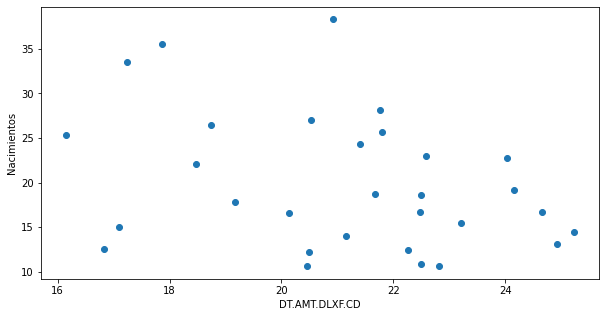

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel("DT.AMT.DLXF.CD")
plt.ylabel("Nacimientos")
plt.scatter("DT.AMT.DLXF.CD", "Nacimientos", data=nacimientos_indicador_df);


In [ ]:
nacimientos_indicador_df.corr()

,DT.AMT.DLXF.CD,Nacimientos
DT.AMT.DLXF.CD,1.000000,-0.324406
Nacimientos,-0.324406,1.000000


No podemos establecer ninguna relación


In [ ]:
#docker
sc.stop()

In [ ]:
#

# FUENTES 
* Apuntes
* Libro :  "Learning PySpark"
* Datacamp: Big Data fundamentals with pyspark
* https://regexr.com/